# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

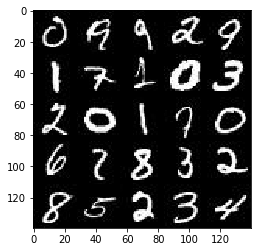

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

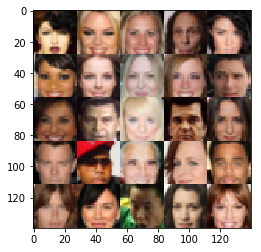

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learningRate = tf.placeholder(tf.float32, None, name='learningRate')

    return inputs_real, inputs_z, learningRate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [6]:
def leaky_relu(x, alpha=0.1, name='leaky_relu'):
    return tf.maximum(x, alpha * x, name=name)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
#Based on last review the following changes were made
#   Added dropouts to layers except for last layer

def discriminator(images, reuse=False, alpha=0.1, keepProb=0.5):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        #Each layer increase depth by x2 and halfs image dimensions.  Initial image dim is 28 with depth 3
        
        l1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        l1 = leaky_relu(l1, alpha)
        l1 = tf.nn.dropout(l1, keepProb)
        # 14x14x64 from 28x28x3
                
        l2 = tf.layers.conv2d(l1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        l2 = tf.layers.batch_normalization(l2, training=True)        
        l2 = leaky_relu(l2, alpha)
        l2 = tf.nn.dropout(l2, keepProb)
        # 7x7x128
        
        l3 = tf.layers.conv2d(l2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        l3 = tf.layers.batch_normalization(l3, training=True)        
        l3 = leaky_relu(l3, alpha)
        l3 = tf.nn.dropout(l3, keepProb)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(l3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
#Based on last review the following changes were made
#   Sharp decrease of filters between 1s and 2nd layer
#   Made generator model larger by increasing filters by a factor of 2 and added 1 more layer
def generator(z, out_channel_dim, is_train=True, alpha=0.1, keepProb=0.5):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    isReuse = not is_train
    with tf.variable_scope('generator', reuse=isReuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*1024)
        # Reshape it to start the convolutional stack        
        x1 = tf.reshape(x1, (-1, 7, 7, 1024))
        
        x1 = tf.layers.batch_normalization(x1, training=is_train)        
        x1 = leaky_relu(x1, alpha)
        x1 = tf.nn.dropout(x1, keepProb)
        # 7x7x1024 now

        #Skipped 512 to have a sharp decrease of filters from layer 1
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)        
        x2 = leaky_relu(x2, alpha)
        x2 = tf.nn.dropout(x2, keepProb)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)        
        x3 = leaky_relu(x3, alpha)
        x3 = tf.nn.dropout(x3, keepProb)
        # 28x28x128 now

        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)        
        x4 = leaky_relu(x4, alpha)
        x4 = tf.nn.dropout(x4, keepProb)
        # 28x28x64 now

        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
#Based on last review the following changes were made
#   Added label smoothing for discriminator real loss

def model_loss(input_real, input_z, out_channel_dim, alpha=0.1, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    #d_loss_real = tf.reduce_mean(
    #    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
        
    return d_loss, g_loss
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha=0.1):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """    
    
    print_every = 10
    show_every = 100
        
    input_real, input_z, learningRate = model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, learningRate, beta1)
    
    #saver = tf.train.Saver()
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
             
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
            
                #Scale images between -1 and 1 since it is now between -0.5 to 0.5
                batch_images = batch_images * 2
                
                # Sample random noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learningRate: learning_rate })
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, learningRate: learning_rate, input_real: batch_images,})
                
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))                    
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)
        
        print("Final images:")        
        show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)
        #saver.save(sess, './checkpoints/generator.ckpt')

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4384... Generator Loss: 2.3674
Epoch 1/2... Discriminator Loss: 1.0598... Generator Loss: 1.9461
Epoch 1/2... Discriminator Loss: 1.5605... Generator Loss: 3.0238
Epoch 1/2... Discriminator Loss: 0.9184... Generator Loss: 1.9678
Epoch 1/2... Discriminator Loss: 0.5660... Generator Loss: 6.7537
Epoch 1/2... Discriminator Loss: 1.8860... Generator Loss: 0.8648
Epoch 1/2... Discriminator Loss: 1.3603... Generator Loss: 2.3169
Epoch 1/2... Discriminator Loss: 1.7875... Generator Loss: 0.8531
Epoch 1/2... Discriminator Loss: 1.3363... Generator Loss: 0.9343
Epoch 1/2... Discriminator Loss: 2.0487... Generator Loss: 0.6881


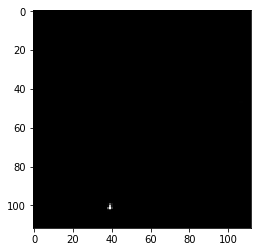

Epoch 1/2... Discriminator Loss: 1.4476... Generator Loss: 1.7256
Epoch 1/2... Discriminator Loss: 1.4368... Generator Loss: 1.4543
Epoch 1/2... Discriminator Loss: 1.6097... Generator Loss: 0.9186
Epoch 1/2... Discriminator Loss: 1.3390... Generator Loss: 0.9798
Epoch 1/2... Discriminator Loss: 1.4004... Generator Loss: 0.7815
Epoch 1/2... Discriminator Loss: 1.3822... Generator Loss: 0.7817
Epoch 1/2... Discriminator Loss: 1.0638... Generator Loss: 1.9033
Epoch 1/2... Discriminator Loss: 1.4708... Generator Loss: 0.8158
Epoch 1/2... Discriminator Loss: 1.3585... Generator Loss: 0.8819
Epoch 1/2... Discriminator Loss: 1.2724... Generator Loss: 0.7604


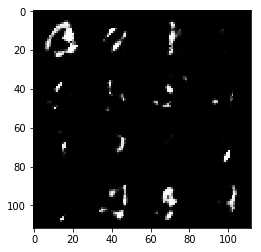

Epoch 1/2... Discriminator Loss: 1.6481... Generator Loss: 0.8280
Epoch 1/2... Discriminator Loss: 1.1907... Generator Loss: 1.4443
Epoch 1/2... Discriminator Loss: 1.4462... Generator Loss: 0.6675
Epoch 1/2... Discriminator Loss: 1.5502... Generator Loss: 2.4231
Epoch 1/2... Discriminator Loss: 1.2703... Generator Loss: 3.0606
Epoch 1/2... Discriminator Loss: 1.4485... Generator Loss: 1.5277
Epoch 1/2... Discriminator Loss: 1.3484... Generator Loss: 1.0339
Epoch 1/2... Discriminator Loss: 1.3687... Generator Loss: 0.9423
Epoch 1/2... Discriminator Loss: 1.1797... Generator Loss: 1.7246
Epoch 1/2... Discriminator Loss: 1.5732... Generator Loss: 0.5522


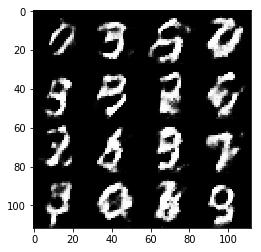

Epoch 1/2... Discriminator Loss: 1.2967... Generator Loss: 0.7089
Epoch 1/2... Discriminator Loss: 1.3075... Generator Loss: 2.2382
Epoch 1/2... Discriminator Loss: 1.2970... Generator Loss: 0.8014
Epoch 1/2... Discriminator Loss: 1.5570... Generator Loss: 0.6507
Epoch 1/2... Discriminator Loss: 1.1772... Generator Loss: 1.9695
Epoch 1/2... Discriminator Loss: 1.2932... Generator Loss: 0.8837
Epoch 1/2... Discriminator Loss: 1.0764... Generator Loss: 1.7797
Epoch 1/2... Discriminator Loss: 1.2509... Generator Loss: 0.7312
Epoch 1/2... Discriminator Loss: 1.1946... Generator Loss: 1.8459
Epoch 1/2... Discriminator Loss: 1.2564... Generator Loss: 1.0499


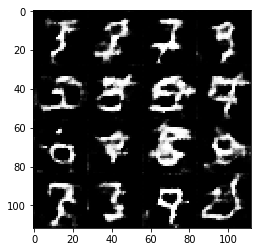

Epoch 1/2... Discriminator Loss: 1.1252... Generator Loss: 1.0601
Epoch 1/2... Discriminator Loss: 1.2730... Generator Loss: 1.6202
Epoch 1/2... Discriminator Loss: 1.2689... Generator Loss: 1.2610
Epoch 1/2... Discriminator Loss: 1.1795... Generator Loss: 1.0062
Epoch 1/2... Discriminator Loss: 1.4889... Generator Loss: 0.7429
Epoch 1/2... Discriminator Loss: 1.6580... Generator Loss: 0.4589
Epoch 1/2... Discriminator Loss: 1.3731... Generator Loss: 2.0143
Epoch 1/2... Discriminator Loss: 1.4981... Generator Loss: 0.8513
Epoch 1/2... Discriminator Loss: 1.2695... Generator Loss: 1.0431
Epoch 1/2... Discriminator Loss: 1.1476... Generator Loss: 0.9461


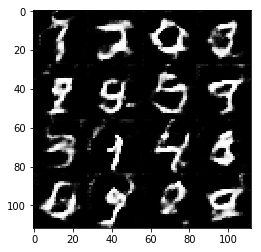

Epoch 1/2... Discriminator Loss: 1.1844... Generator Loss: 1.4419
Epoch 1/2... Discriminator Loss: 1.0496... Generator Loss: 0.7931
Epoch 1/2... Discriminator Loss: 1.1898... Generator Loss: 1.1577
Epoch 1/2... Discriminator Loss: 1.2437... Generator Loss: 1.1218
Epoch 1/2... Discriminator Loss: 1.3652... Generator Loss: 1.4101
Epoch 1/2... Discriminator Loss: 1.6646... Generator Loss: 1.5989
Epoch 1/2... Discriminator Loss: 1.1082... Generator Loss: 0.9384
Epoch 1/2... Discriminator Loss: 1.1725... Generator Loss: 1.3102
Epoch 1/2... Discriminator Loss: 1.1788... Generator Loss: 0.8646
Epoch 1/2... Discriminator Loss: 1.5239... Generator Loss: 1.0324


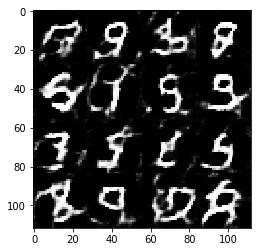

Epoch 1/2... Discriminator Loss: 1.0569... Generator Loss: 0.8777
Epoch 1/2... Discriminator Loss: 1.2501... Generator Loss: 1.2320
Epoch 1/2... Discriminator Loss: 1.2198... Generator Loss: 0.8492
Epoch 1/2... Discriminator Loss: 1.2692... Generator Loss: 1.7711
Epoch 1/2... Discriminator Loss: 1.4539... Generator Loss: 1.8867
Epoch 1/2... Discriminator Loss: 1.4894... Generator Loss: 0.6869
Epoch 1/2... Discriminator Loss: 1.6299... Generator Loss: 2.1980
Epoch 1/2... Discriminator Loss: 1.1251... Generator Loss: 0.8955
Epoch 1/2... Discriminator Loss: 1.4634... Generator Loss: 0.7849
Epoch 1/2... Discriminator Loss: 1.5264... Generator Loss: 1.7920


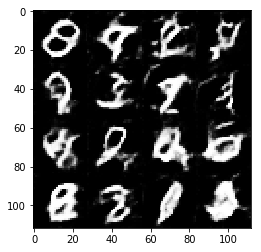

Epoch 1/2... Discriminator Loss: 1.1634... Generator Loss: 1.0992
Epoch 1/2... Discriminator Loss: 1.2521... Generator Loss: 1.0781
Epoch 1/2... Discriminator Loss: 1.0920... Generator Loss: 1.4567
Epoch 1/2... Discriminator Loss: 1.0947... Generator Loss: 1.1868
Epoch 1/2... Discriminator Loss: 1.1405... Generator Loss: 1.0024
Epoch 1/2... Discriminator Loss: 1.3343... Generator Loss: 1.3549
Epoch 1/2... Discriminator Loss: 1.1422... Generator Loss: 1.0798
Epoch 1/2... Discriminator Loss: 1.1609... Generator Loss: 1.5890
Epoch 1/2... Discriminator Loss: 1.1464... Generator Loss: 1.3830
Epoch 1/2... Discriminator Loss: 1.3641... Generator Loss: 1.3416


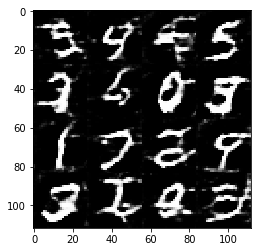

Epoch 1/2... Discriminator Loss: 1.2109... Generator Loss: 1.4513
Epoch 1/2... Discriminator Loss: 1.1526... Generator Loss: 1.1295
Epoch 1/2... Discriminator Loss: 1.1283... Generator Loss: 0.8563
Epoch 1/2... Discriminator Loss: 1.0151... Generator Loss: 1.4111
Epoch 1/2... Discriminator Loss: 1.1437... Generator Loss: 0.9474
Epoch 1/2... Discriminator Loss: 1.1104... Generator Loss: 0.8775
Epoch 1/2... Discriminator Loss: 1.1131... Generator Loss: 1.7328
Epoch 1/2... Discriminator Loss: 1.3280... Generator Loss: 1.5170
Epoch 1/2... Discriminator Loss: 1.1250... Generator Loss: 1.0433
Epoch 1/2... Discriminator Loss: 1.2498... Generator Loss: 1.3138


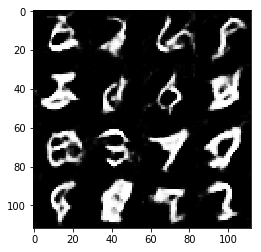

Epoch 1/2... Discriminator Loss: 1.2291... Generator Loss: 0.7075
Epoch 1/2... Discriminator Loss: 1.2683... Generator Loss: 0.8416
Epoch 1/2... Discriminator Loss: 1.2754... Generator Loss: 1.0240
Epoch 1/2... Discriminator Loss: 1.1427... Generator Loss: 0.8160
Epoch 1/2... Discriminator Loss: 1.1605... Generator Loss: 0.9523
Epoch 1/2... Discriminator Loss: 1.5198... Generator Loss: 0.9922
Epoch 1/2... Discriminator Loss: 1.2568... Generator Loss: 1.2198
Epoch 1/2... Discriminator Loss: 1.2880... Generator Loss: 1.8432
Epoch 1/2... Discriminator Loss: 1.2640... Generator Loss: 1.5018
Epoch 1/2... Discriminator Loss: 1.2726... Generator Loss: 0.9919


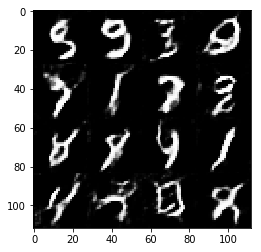

Epoch 1/2... Discriminator Loss: 1.2192... Generator Loss: 1.4009
Epoch 1/2... Discriminator Loss: 1.3834... Generator Loss: 0.7306
Epoch 1/2... Discriminator Loss: 1.2130... Generator Loss: 1.1700
Epoch 1/2... Discriminator Loss: 1.1737... Generator Loss: 1.0520
Epoch 1/2... Discriminator Loss: 1.2242... Generator Loss: 1.2961
Epoch 1/2... Discriminator Loss: 1.3001... Generator Loss: 1.0509
Epoch 1/2... Discriminator Loss: 1.3217... Generator Loss: 0.8806
Epoch 1/2... Discriminator Loss: 1.3390... Generator Loss: 0.8604
Epoch 1/2... Discriminator Loss: 1.2726... Generator Loss: 1.5637
Epoch 1/2... Discriminator Loss: 1.2605... Generator Loss: 1.3688


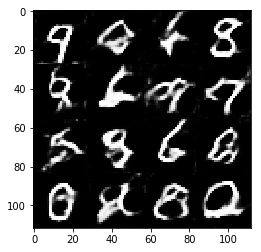

Epoch 1/2... Discriminator Loss: 1.6390... Generator Loss: 0.6705
Epoch 1/2... Discriminator Loss: 1.0299... Generator Loss: 1.3674
Epoch 1/2... Discriminator Loss: 0.9989... Generator Loss: 1.1606
Epoch 1/2... Discriminator Loss: 1.3770... Generator Loss: 1.6206
Epoch 1/2... Discriminator Loss: 1.1808... Generator Loss: 0.9431
Epoch 1/2... Discriminator Loss: 1.3212... Generator Loss: 0.8968
Epoch 1/2... Discriminator Loss: 1.1396... Generator Loss: 1.3790
Epoch 1/2... Discriminator Loss: 1.3883... Generator Loss: 0.8637
Epoch 1/2... Discriminator Loss: 1.2563... Generator Loss: 1.2942
Epoch 1/2... Discriminator Loss: 1.2538... Generator Loss: 0.8238


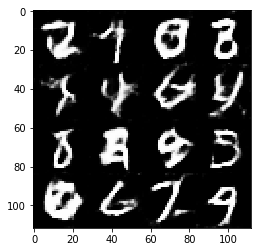

Epoch 1/2... Discriminator Loss: 1.4025... Generator Loss: 0.9612
Epoch 1/2... Discriminator Loss: 1.2423... Generator Loss: 0.8392
Epoch 1/2... Discriminator Loss: 1.0604... Generator Loss: 1.1333
Epoch 1/2... Discriminator Loss: 1.1502... Generator Loss: 1.2642
Epoch 1/2... Discriminator Loss: 1.4947... Generator Loss: 0.8994
Epoch 1/2... Discriminator Loss: 1.2576... Generator Loss: 0.8838
Epoch 1/2... Discriminator Loss: 1.1216... Generator Loss: 0.9472
Epoch 1/2... Discriminator Loss: 1.1868... Generator Loss: 1.4378
Epoch 1/2... Discriminator Loss: 1.2922... Generator Loss: 1.3245
Epoch 1/2... Discriminator Loss: 1.1921... Generator Loss: 1.1635


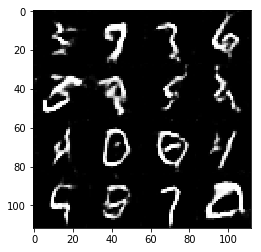

Epoch 1/2... Discriminator Loss: 1.1598... Generator Loss: 1.0162
Epoch 1/2... Discriminator Loss: 1.2124... Generator Loss: 1.2721
Epoch 1/2... Discriminator Loss: 1.0184... Generator Loss: 1.5206
Epoch 1/2... Discriminator Loss: 1.2782... Generator Loss: 1.1720
Epoch 1/2... Discriminator Loss: 1.1556... Generator Loss: 1.0271
Epoch 1/2... Discriminator Loss: 1.2999... Generator Loss: 1.2623
Epoch 1/2... Discriminator Loss: 1.1189... Generator Loss: 1.0502
Epoch 1/2... Discriminator Loss: 1.1151... Generator Loss: 1.2170
Epoch 1/2... Discriminator Loss: 1.3315... Generator Loss: 0.9220
Epoch 1/2... Discriminator Loss: 1.1723... Generator Loss: 1.1041


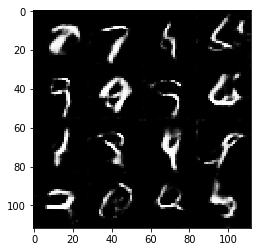

Epoch 1/2... Discriminator Loss: 1.2458... Generator Loss: 1.1955
Epoch 1/2... Discriminator Loss: 1.2677... Generator Loss: 1.1296
Epoch 1/2... Discriminator Loss: 1.3914... Generator Loss: 0.9175
Epoch 1/2... Discriminator Loss: 1.0099... Generator Loss: 0.9888
Epoch 1/2... Discriminator Loss: 1.3065... Generator Loss: 0.8810
Epoch 1/2... Discriminator Loss: 1.2235... Generator Loss: 1.9186
Epoch 1/2... Discriminator Loss: 1.1654... Generator Loss: 0.6746
Epoch 1/2... Discriminator Loss: 1.2018... Generator Loss: 0.9850
Epoch 1/2... Discriminator Loss: 1.0937... Generator Loss: 1.0670
Epoch 1/2... Discriminator Loss: 1.3369... Generator Loss: 0.8085


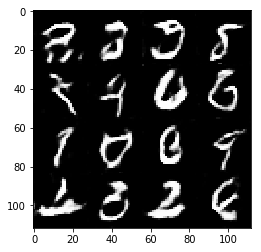

Epoch 1/2... Discriminator Loss: 1.2098... Generator Loss: 1.2461
Epoch 1/2... Discriminator Loss: 1.4109... Generator Loss: 1.7662
Epoch 1/2... Discriminator Loss: 1.2556... Generator Loss: 1.1917
Epoch 1/2... Discriminator Loss: 1.1462... Generator Loss: 1.0756
Epoch 1/2... Discriminator Loss: 1.1718... Generator Loss: 1.0601
Epoch 1/2... Discriminator Loss: 1.5228... Generator Loss: 0.9262
Epoch 1/2... Discriminator Loss: 1.3497... Generator Loss: 0.7089
Epoch 1/2... Discriminator Loss: 1.2757... Generator Loss: 0.8088
Epoch 1/2... Discriminator Loss: 1.0816... Generator Loss: 1.1078
Epoch 1/2... Discriminator Loss: 1.4332... Generator Loss: 0.7779


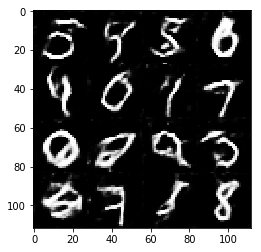

Epoch 1/2... Discriminator Loss: 1.1870... Generator Loss: 1.0655
Epoch 1/2... Discriminator Loss: 0.9885... Generator Loss: 1.1102
Epoch 1/2... Discriminator Loss: 1.1400... Generator Loss: 1.3974
Epoch 1/2... Discriminator Loss: 1.3030... Generator Loss: 1.1708
Epoch 1/2... Discriminator Loss: 1.2149... Generator Loss: 1.1160
Epoch 1/2... Discriminator Loss: 1.1618... Generator Loss: 1.3240
Epoch 1/2... Discriminator Loss: 0.8768... Generator Loss: 1.3098
Epoch 1/2... Discriminator Loss: 1.2463... Generator Loss: 1.3813
Epoch 1/2... Discriminator Loss: 1.3941... Generator Loss: 0.7687
Epoch 1/2... Discriminator Loss: 1.2061... Generator Loss: 0.8931


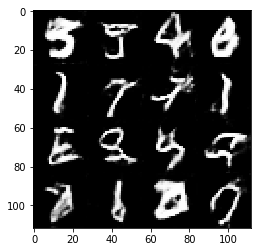

Epoch 1/2... Discriminator Loss: 1.2012... Generator Loss: 1.4052
Epoch 1/2... Discriminator Loss: 1.4578... Generator Loss: 0.8440
Epoch 1/2... Discriminator Loss: 1.3128... Generator Loss: 1.5378
Epoch 1/2... Discriminator Loss: 1.1472... Generator Loss: 0.7977
Epoch 1/2... Discriminator Loss: 1.1934... Generator Loss: 1.4134
Epoch 1/2... Discriminator Loss: 1.3165... Generator Loss: 0.8741
Epoch 1/2... Discriminator Loss: 1.2601... Generator Loss: 1.5143
Epoch 1/2... Discriminator Loss: 1.2078... Generator Loss: 1.2846
Epoch 1/2... Discriminator Loss: 1.3209... Generator Loss: 0.7586
Epoch 1/2... Discriminator Loss: 1.1831... Generator Loss: 0.9587


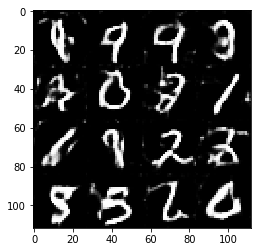

Epoch 1/2... Discriminator Loss: 1.4192... Generator Loss: 0.8077
Epoch 1/2... Discriminator Loss: 1.3899... Generator Loss: 0.8701
Epoch 1/2... Discriminator Loss: 1.2533... Generator Loss: 1.0720
Epoch 1/2... Discriminator Loss: 1.0700... Generator Loss: 1.4518
Epoch 1/2... Discriminator Loss: 1.2130... Generator Loss: 1.0153
Epoch 1/2... Discriminator Loss: 1.0980... Generator Loss: 1.3645
Epoch 1/2... Discriminator Loss: 1.3352... Generator Loss: 1.3902
Epoch 2/2... Discriminator Loss: 1.2067... Generator Loss: 1.4159
Epoch 2/2... Discriminator Loss: 1.2769... Generator Loss: 0.7700
Epoch 2/2... Discriminator Loss: 0.9560... Generator Loss: 1.1955


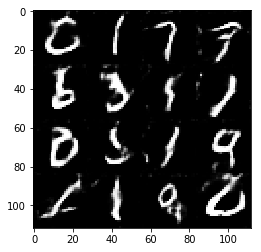

Epoch 2/2... Discriminator Loss: 1.2898... Generator Loss: 1.2965
Epoch 2/2... Discriminator Loss: 1.3199... Generator Loss: 0.8923
Epoch 2/2... Discriminator Loss: 1.0624... Generator Loss: 1.1882
Epoch 2/2... Discriminator Loss: 1.2869... Generator Loss: 1.3608
Epoch 2/2... Discriminator Loss: 1.1584... Generator Loss: 1.0198
Epoch 2/2... Discriminator Loss: 1.1389... Generator Loss: 1.1276
Epoch 2/2... Discriminator Loss: 1.2503... Generator Loss: 1.5721
Epoch 2/2... Discriminator Loss: 1.3436... Generator Loss: 1.0059
Epoch 2/2... Discriminator Loss: 1.3347... Generator Loss: 1.2689
Epoch 2/2... Discriminator Loss: 1.2695... Generator Loss: 1.4783


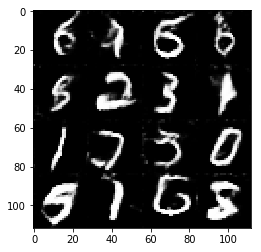

Epoch 2/2... Discriminator Loss: 1.1991... Generator Loss: 1.4052
Epoch 2/2... Discriminator Loss: 1.3122... Generator Loss: 1.0830
Epoch 2/2... Discriminator Loss: 1.3924... Generator Loss: 0.6625
Epoch 2/2... Discriminator Loss: 1.1325... Generator Loss: 1.0572
Epoch 2/2... Discriminator Loss: 1.4620... Generator Loss: 1.2374
Epoch 2/2... Discriminator Loss: 1.0228... Generator Loss: 1.6528
Epoch 2/2... Discriminator Loss: 1.1245... Generator Loss: 1.1573
Epoch 2/2... Discriminator Loss: 1.0585... Generator Loss: 1.9144
Epoch 2/2... Discriminator Loss: 1.1349... Generator Loss: 1.3405
Epoch 2/2... Discriminator Loss: 1.4631... Generator Loss: 0.6602


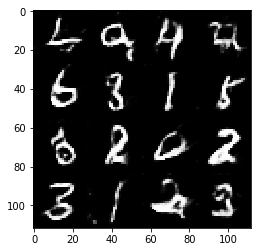

Epoch 2/2... Discriminator Loss: 1.1531... Generator Loss: 1.4433
Epoch 2/2... Discriminator Loss: 1.1772... Generator Loss: 1.2315
Epoch 2/2... Discriminator Loss: 1.0862... Generator Loss: 1.2355
Epoch 2/2... Discriminator Loss: 1.2485... Generator Loss: 0.9622
Epoch 2/2... Discriminator Loss: 1.2670... Generator Loss: 0.9287
Epoch 2/2... Discriminator Loss: 1.1032... Generator Loss: 1.0589
Epoch 2/2... Discriminator Loss: 1.2851... Generator Loss: 1.5035
Epoch 2/2... Discriminator Loss: 1.2813... Generator Loss: 1.0540
Epoch 2/2... Discriminator Loss: 0.9925... Generator Loss: 1.1187
Epoch 2/2... Discriminator Loss: 1.2438... Generator Loss: 0.8939


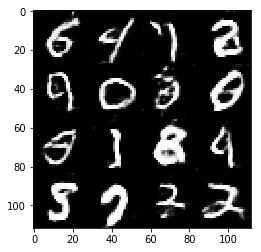

Epoch 2/2... Discriminator Loss: 1.1172... Generator Loss: 1.3242
Epoch 2/2... Discriminator Loss: 1.1340... Generator Loss: 1.6501
Epoch 2/2... Discriminator Loss: 1.1672... Generator Loss: 0.9284
Epoch 2/2... Discriminator Loss: 1.1769... Generator Loss: 1.0955
Epoch 2/2... Discriminator Loss: 1.2722... Generator Loss: 1.0764
Epoch 2/2... Discriminator Loss: 1.2530... Generator Loss: 1.3734
Epoch 2/2... Discriminator Loss: 1.0937... Generator Loss: 1.2838
Epoch 2/2... Discriminator Loss: 1.4299... Generator Loss: 0.9760
Epoch 2/2... Discriminator Loss: 0.9822... Generator Loss: 1.3791
Epoch 2/2... Discriminator Loss: 1.1152... Generator Loss: 1.1492


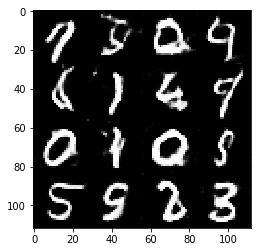

Epoch 2/2... Discriminator Loss: 1.3726... Generator Loss: 1.4511
Epoch 2/2... Discriminator Loss: 1.4442... Generator Loss: 1.0348
Epoch 2/2... Discriminator Loss: 0.9085... Generator Loss: 1.3152
Epoch 2/2... Discriminator Loss: 1.0566... Generator Loss: 1.1257
Epoch 2/2... Discriminator Loss: 1.1137... Generator Loss: 0.7439
Epoch 2/2... Discriminator Loss: 0.9760... Generator Loss: 1.1641
Epoch 2/2... Discriminator Loss: 1.0243... Generator Loss: 1.5043
Epoch 2/2... Discriminator Loss: 1.3929... Generator Loss: 1.0164
Epoch 2/2... Discriminator Loss: 1.1710... Generator Loss: 1.5327
Epoch 2/2... Discriminator Loss: 0.9931... Generator Loss: 1.3269


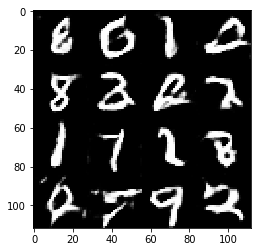

Epoch 2/2... Discriminator Loss: 1.2277... Generator Loss: 1.1052
Epoch 2/2... Discriminator Loss: 1.0586... Generator Loss: 1.2760
Epoch 2/2... Discriminator Loss: 1.3924... Generator Loss: 0.9871
Epoch 2/2... Discriminator Loss: 1.0678... Generator Loss: 0.9191
Epoch 2/2... Discriminator Loss: 1.2758... Generator Loss: 1.3968
Epoch 2/2... Discriminator Loss: 1.4538... Generator Loss: 1.4541
Epoch 2/2... Discriminator Loss: 1.3168... Generator Loss: 1.1366
Epoch 2/2... Discriminator Loss: 1.2948... Generator Loss: 1.0954
Epoch 2/2... Discriminator Loss: 1.0932... Generator Loss: 0.9979
Epoch 2/2... Discriminator Loss: 1.1504... Generator Loss: 1.3539


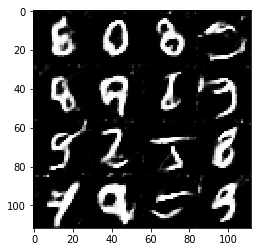

Epoch 2/2... Discriminator Loss: 1.2483... Generator Loss: 0.9551
Epoch 2/2... Discriminator Loss: 1.2305... Generator Loss: 1.5240
Epoch 2/2... Discriminator Loss: 1.1807... Generator Loss: 2.0980
Epoch 2/2... Discriminator Loss: 1.1362... Generator Loss: 1.6214
Epoch 2/2... Discriminator Loss: 1.3533... Generator Loss: 1.0152
Epoch 2/2... Discriminator Loss: 1.1862... Generator Loss: 1.1768
Epoch 2/2... Discriminator Loss: 0.9986... Generator Loss: 1.2777
Epoch 2/2... Discriminator Loss: 1.2186... Generator Loss: 1.2108
Epoch 2/2... Discriminator Loss: 1.3028... Generator Loss: 0.9056
Epoch 2/2... Discriminator Loss: 0.9301... Generator Loss: 1.2163


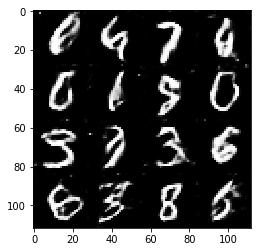

Epoch 2/2... Discriminator Loss: 1.2193... Generator Loss: 1.1790
Epoch 2/2... Discriminator Loss: 1.1670... Generator Loss: 1.4225
Epoch 2/2... Discriminator Loss: 1.1766... Generator Loss: 1.1003
Epoch 2/2... Discriminator Loss: 1.1335... Generator Loss: 1.0695
Epoch 2/2... Discriminator Loss: 0.9945... Generator Loss: 1.4532
Epoch 2/2... Discriminator Loss: 1.2399... Generator Loss: 1.3626
Epoch 2/2... Discriminator Loss: 1.3235... Generator Loss: 0.8052
Epoch 2/2... Discriminator Loss: 1.3235... Generator Loss: 1.1066
Epoch 2/2... Discriminator Loss: 1.4556... Generator Loss: 1.3373
Epoch 2/2... Discriminator Loss: 1.0654... Generator Loss: 1.1595


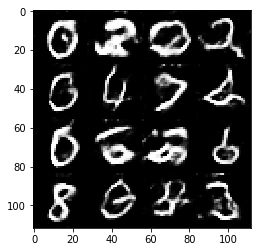

Epoch 2/2... Discriminator Loss: 1.3620... Generator Loss: 0.9203
Epoch 2/2... Discriminator Loss: 1.0864... Generator Loss: 1.4810
Epoch 2/2... Discriminator Loss: 1.0735... Generator Loss: 0.8888
Epoch 2/2... Discriminator Loss: 1.2449... Generator Loss: 1.3441
Epoch 2/2... Discriminator Loss: 1.1435... Generator Loss: 1.5600
Epoch 2/2... Discriminator Loss: 1.2232... Generator Loss: 0.6649
Epoch 2/2... Discriminator Loss: 0.9301... Generator Loss: 1.7861
Epoch 2/2... Discriminator Loss: 1.1854... Generator Loss: 1.3131
Epoch 2/2... Discriminator Loss: 1.1683... Generator Loss: 1.9077
Epoch 2/2... Discriminator Loss: 1.1355... Generator Loss: 1.3450


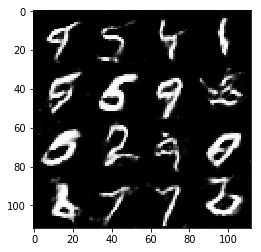

Epoch 2/2... Discriminator Loss: 1.2803... Generator Loss: 1.3152
Epoch 2/2... Discriminator Loss: 0.9450... Generator Loss: 1.1186
Epoch 2/2... Discriminator Loss: 1.1872... Generator Loss: 1.2381
Epoch 2/2... Discriminator Loss: 1.0686... Generator Loss: 0.9271
Epoch 2/2... Discriminator Loss: 1.1871... Generator Loss: 0.9307
Epoch 2/2... Discriminator Loss: 1.1706... Generator Loss: 1.0350
Epoch 2/2... Discriminator Loss: 1.2728... Generator Loss: 0.8046
Epoch 2/2... Discriminator Loss: 1.3439... Generator Loss: 1.0839
Epoch 2/2... Discriminator Loss: 1.0062... Generator Loss: 1.4681
Epoch 2/2... Discriminator Loss: 1.2382... Generator Loss: 0.9774


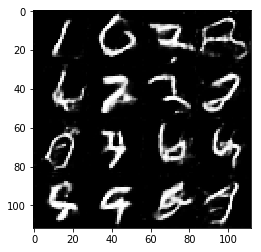

Epoch 2/2... Discriminator Loss: 1.0771... Generator Loss: 1.3847
Epoch 2/2... Discriminator Loss: 1.0586... Generator Loss: 1.2302
Epoch 2/2... Discriminator Loss: 1.2364... Generator Loss: 1.8054
Epoch 2/2... Discriminator Loss: 1.3218... Generator Loss: 1.5370
Epoch 2/2... Discriminator Loss: 1.0930... Generator Loss: 1.6556
Epoch 2/2... Discriminator Loss: 1.0216... Generator Loss: 1.4289
Epoch 2/2... Discriminator Loss: 1.1494... Generator Loss: 1.3032
Epoch 2/2... Discriminator Loss: 1.2543... Generator Loss: 0.7179
Epoch 2/2... Discriminator Loss: 1.0482... Generator Loss: 0.9833
Epoch 2/2... Discriminator Loss: 1.1178... Generator Loss: 1.4137


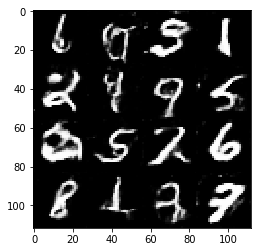

Epoch 2/2... Discriminator Loss: 1.3087... Generator Loss: 1.3197
Epoch 2/2... Discriminator Loss: 1.1665... Generator Loss: 1.3930
Epoch 2/2... Discriminator Loss: 1.1175... Generator Loss: 1.1642
Epoch 2/2... Discriminator Loss: 1.3073... Generator Loss: 1.4279
Epoch 2/2... Discriminator Loss: 1.1184... Generator Loss: 0.9413
Epoch 2/2... Discriminator Loss: 0.8860... Generator Loss: 0.8783
Epoch 2/2... Discriminator Loss: 1.0710... Generator Loss: 1.3648
Epoch 2/2... Discriminator Loss: 1.2162... Generator Loss: 1.3280
Epoch 2/2... Discriminator Loss: 1.1338... Generator Loss: 1.0357
Epoch 2/2... Discriminator Loss: 1.2505... Generator Loss: 0.9261


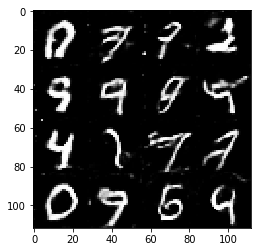

Epoch 2/2... Discriminator Loss: 1.2795... Generator Loss: 0.9345
Epoch 2/2... Discriminator Loss: 0.9532... Generator Loss: 1.4342
Epoch 2/2... Discriminator Loss: 1.2828... Generator Loss: 1.5730
Epoch 2/2... Discriminator Loss: 1.0357... Generator Loss: 1.1363
Epoch 2/2... Discriminator Loss: 1.2137... Generator Loss: 1.6758
Epoch 2/2... Discriminator Loss: 0.9656... Generator Loss: 1.2812
Epoch 2/2... Discriminator Loss: 1.0804... Generator Loss: 1.0726
Epoch 2/2... Discriminator Loss: 1.3727... Generator Loss: 1.6191
Epoch 2/2... Discriminator Loss: 1.4325... Generator Loss: 1.3544
Epoch 2/2... Discriminator Loss: 1.4042... Generator Loss: 1.2998


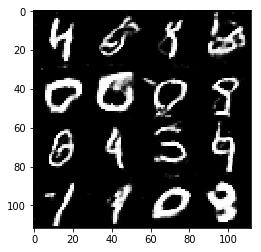

Epoch 2/2... Discriminator Loss: 1.1965... Generator Loss: 1.3907
Epoch 2/2... Discriminator Loss: 1.0621... Generator Loss: 1.2641
Epoch 2/2... Discriminator Loss: 1.3076... Generator Loss: 1.2626
Epoch 2/2... Discriminator Loss: 1.0455... Generator Loss: 1.0415
Epoch 2/2... Discriminator Loss: 1.3373... Generator Loss: 1.2830
Epoch 2/2... Discriminator Loss: 1.1022... Generator Loss: 1.2259
Epoch 2/2... Discriminator Loss: 1.0647... Generator Loss: 1.2315
Epoch 2/2... Discriminator Loss: 1.0791... Generator Loss: 0.7647
Epoch 2/2... Discriminator Loss: 1.1816... Generator Loss: 1.0528
Epoch 2/2... Discriminator Loss: 1.2140... Generator Loss: 1.4244


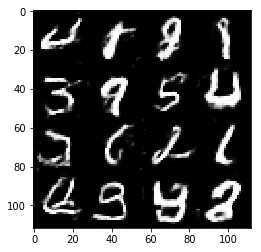

Epoch 2/2... Discriminator Loss: 1.1723... Generator Loss: 0.8882
Epoch 2/2... Discriminator Loss: 1.1753... Generator Loss: 1.2330
Epoch 2/2... Discriminator Loss: 1.3199... Generator Loss: 1.2459
Epoch 2/2... Discriminator Loss: 1.1188... Generator Loss: 1.1344
Epoch 2/2... Discriminator Loss: 1.1548... Generator Loss: 1.7147
Epoch 2/2... Discriminator Loss: 1.0195... Generator Loss: 1.2882
Epoch 2/2... Discriminator Loss: 1.2382... Generator Loss: 0.9141
Epoch 2/2... Discriminator Loss: 1.1770... Generator Loss: 1.2090
Epoch 2/2... Discriminator Loss: 0.9707... Generator Loss: 1.3849
Epoch 2/2... Discriminator Loss: 1.1218... Generator Loss: 1.0694


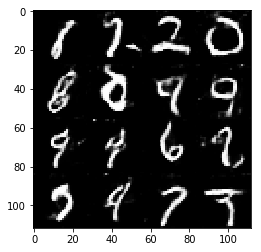

Epoch 2/2... Discriminator Loss: 1.1321... Generator Loss: 1.2853
Epoch 2/2... Discriminator Loss: 1.2688... Generator Loss: 1.2487
Epoch 2/2... Discriminator Loss: 0.9666... Generator Loss: 0.9488
Epoch 2/2... Discriminator Loss: 0.8033... Generator Loss: 1.4535
Epoch 2/2... Discriminator Loss: 1.2803... Generator Loss: 0.8141
Epoch 2/2... Discriminator Loss: 1.1942... Generator Loss: 0.8448
Epoch 2/2... Discriminator Loss: 1.0402... Generator Loss: 1.4918
Epoch 2/2... Discriminator Loss: 1.3311... Generator Loss: 1.3965
Epoch 2/2... Discriminator Loss: 0.8734... Generator Loss: 1.1359
Epoch 2/2... Discriminator Loss: 1.1545... Generator Loss: 1.5064


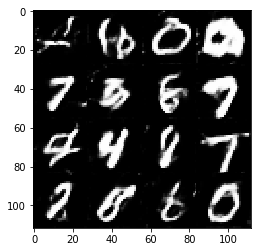

Epoch 2/2... Discriminator Loss: 1.1520... Generator Loss: 1.0780
Epoch 2/2... Discriminator Loss: 1.0196... Generator Loss: 1.1731
Epoch 2/2... Discriminator Loss: 0.9883... Generator Loss: 1.2383
Epoch 2/2... Discriminator Loss: 1.2930... Generator Loss: 1.0317
Epoch 2/2... Discriminator Loss: 1.2875... Generator Loss: 1.4708
Epoch 2/2... Discriminator Loss: 1.1019... Generator Loss: 1.2515
Epoch 2/2... Discriminator Loss: 1.1672... Generator Loss: 1.4821
Epoch 2/2... Discriminator Loss: 1.5090... Generator Loss: 0.9195
Epoch 2/2... Discriminator Loss: 1.2928... Generator Loss: 1.1926
Epoch 2/2... Discriminator Loss: 1.1587... Generator Loss: 1.3620


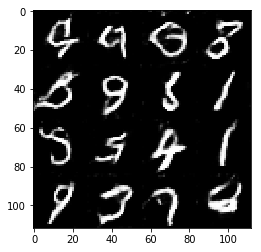

Epoch 2/2... Discriminator Loss: 1.1162... Generator Loss: 0.7840
Epoch 2/2... Discriminator Loss: 1.2933... Generator Loss: 1.2111
Epoch 2/2... Discriminator Loss: 1.1263... Generator Loss: 1.1989
Epoch 2/2... Discriminator Loss: 1.3361... Generator Loss: 1.0145
Epoch 2/2... Discriminator Loss: 0.9206... Generator Loss: 1.0808
Epoch 2/2... Discriminator Loss: 1.0109... Generator Loss: 1.2190
Epoch 2/2... Discriminator Loss: 0.9767... Generator Loss: 0.9715
Epoch 2/2... Discriminator Loss: 1.2120... Generator Loss: 1.3765
Epoch 2/2... Discriminator Loss: 1.4515... Generator Loss: 1.0582
Epoch 2/2... Discriminator Loss: 1.2271... Generator Loss: 1.0734


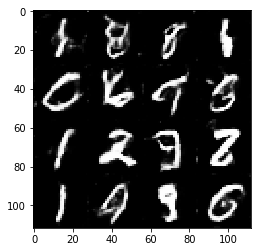

Epoch 2/2... Discriminator Loss: 1.2047... Generator Loss: 1.1159
Epoch 2/2... Discriminator Loss: 1.0624... Generator Loss: 1.7377
Epoch 2/2... Discriminator Loss: 1.0877... Generator Loss: 1.0537
Epoch 2/2... Discriminator Loss: 0.9728... Generator Loss: 2.1039
Epoch 2/2... Discriminator Loss: 1.1785... Generator Loss: 1.3956
Final images:


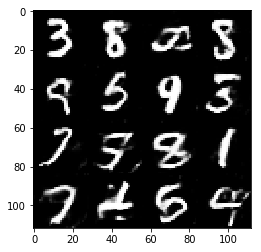

In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0015
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6091... Generator Loss: 2.9437
Epoch 1/1... Discriminator Loss: 0.5997... Generator Loss: 3.5167
Epoch 1/1... Discriminator Loss: 0.6478... Generator Loss: 3.7582
Epoch 1/1... Discriminator Loss: 0.6860... Generator Loss: 2.6554
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 2.0606
Epoch 1/1... Discriminator Loss: 0.8726... Generator Loss: 2.2954
Epoch 1/1... Discriminator Loss: 0.8321... Generator Loss: 2.8751
Epoch 1/1... Discriminator Loss: 0.7182... Generator Loss: 3.1643
Epoch 1/1... Discriminator Loss: 0.6152... Generator Loss: 4.9164
Epoch 1/1... Discriminator Loss: 0.5406... Generator Loss: 3.1464


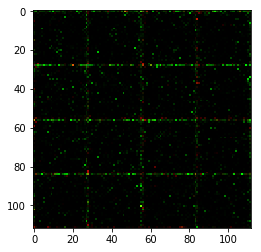

Epoch 1/1... Discriminator Loss: 0.5767... Generator Loss: 2.9820
Epoch 1/1... Discriminator Loss: 0.4380... Generator Loss: 6.3922
Epoch 1/1... Discriminator Loss: 0.5069... Generator Loss: 4.0130
Epoch 1/1... Discriminator Loss: 0.5492... Generator Loss: 4.4452
Epoch 1/1... Discriminator Loss: 0.4911... Generator Loss: 4.9177
Epoch 1/1... Discriminator Loss: 0.5988... Generator Loss: 2.6325
Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 6.4206
Epoch 1/1... Discriminator Loss: 0.4643... Generator Loss: 3.4712
Epoch 1/1... Discriminator Loss: 0.5905... Generator Loss: 2.9979
Epoch 1/1... Discriminator Loss: 0.7050... Generator Loss: 1.7248


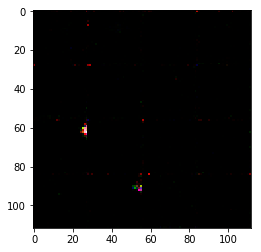

Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 0.5626... Generator Loss: 3.1129
Epoch 1/1... Discriminator Loss: 0.6580... Generator Loss: 2.5321
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 2.3298
Epoch 1/1... Discriminator Loss: 0.7412... Generator Loss: 2.4697
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 3.0813
Epoch 1/1... Discriminator Loss: 0.8901... Generator Loss: 2.1784
Epoch 1/1... Discriminator Loss: 0.9538... Generator Loss: 1.7468
Epoch 1/1... Discriminator Loss: 1.9305... Generator Loss: 2.2998
Epoch 1/1... Discriminator Loss: 0.7949... Generator Loss: 2.9937


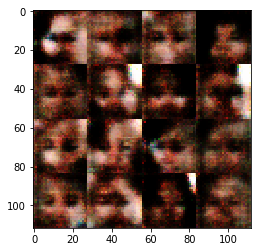

Epoch 1/1... Discriminator Loss: 0.7527... Generator Loss: 2.4783
Epoch 1/1... Discriminator Loss: 0.6735... Generator Loss: 1.7639
Epoch 1/1... Discriminator Loss: 2.2734... Generator Loss: 4.2639
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 2.4531
Epoch 1/1... Discriminator Loss: 1.0416... Generator Loss: 1.5144
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 1.1573
Epoch 1/1... Discriminator Loss: 1.6093... Generator Loss: 2.6208
Epoch 1/1... Discriminator Loss: 1.0451... Generator Loss: 1.8682
Epoch 1/1... Discriminator Loss: 1.5703... Generator Loss: 1.3129
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 1.1846


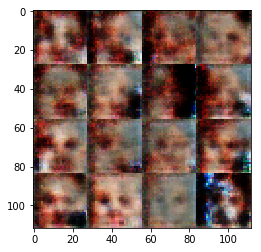

Epoch 1/1... Discriminator Loss: 0.9353... Generator Loss: 1.4419
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 0.9447
Epoch 1/1... Discriminator Loss: 1.0030... Generator Loss: 1.4688
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 1.3154
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 1.1278
Epoch 1/1... Discriminator Loss: 1.0929... Generator Loss: 2.2588
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 1.4875
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 1.3990
Epoch 1/1... Discriminator Loss: 1.6891... Generator Loss: 0.6969


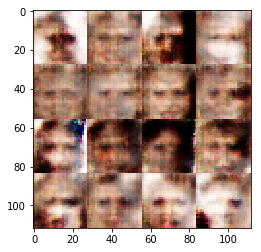

Epoch 1/1... Discriminator Loss: 0.8323... Generator Loss: 1.2788
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 1.5900
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 1.3782
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 1.2984
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 1.2895
Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 1.4059
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 1.5537
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 1.0420


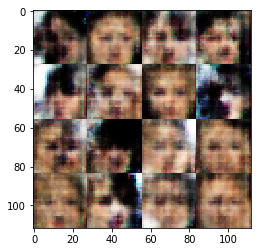

Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 1.5869
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.9460
Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 1.3816
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 1.4764
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 1.0432
Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 1.1880
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 1.3234
Epoch 1/1... Discriminator Loss: 1.6581... Generator Loss: 0.5196
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 1.5363... Generator Loss: 1.0460


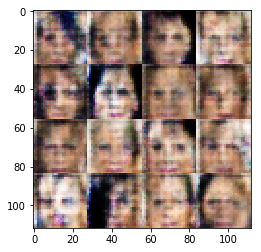

Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 1.0202
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 1.2872
Epoch 1/1... Discriminator Loss: 1.8665... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 1.6409
Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 1.1322
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 1.2218
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 1.2799
Epoch 1/1... Discriminator Loss: 0.9088... Generator Loss: 1.1695
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 1.0852
Epoch 1/1... Discriminator Loss: 1.5959... Generator Loss: 0.9625


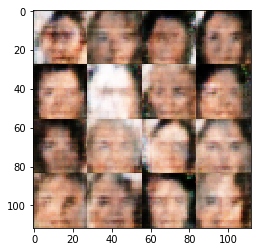

Epoch 1/1... Discriminator Loss: 1.6188... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 1.4301
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 1.0177
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 1.1971
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 1.0332
Epoch 1/1... Discriminator Loss: 0.8086... Generator Loss: 1.0562
Epoch 1/1... Discriminator Loss: 1.6554... Generator Loss: 0.6174
Epoch 1/1... Discriminator Loss: 1.5105... Generator Loss: 0.6610


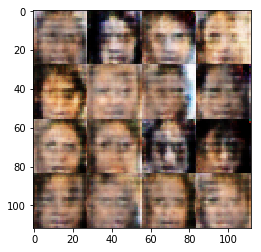

Epoch 1/1... Discriminator Loss: 0.9208... Generator Loss: 1.4609
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 1.0764
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 1.3709
Epoch 1/1... Discriminator Loss: 1.5941... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 1.5713
Epoch 1/1... Discriminator Loss: 1.6510... Generator Loss: 0.9216
Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 1.7099
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 1.4445
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 1.1125


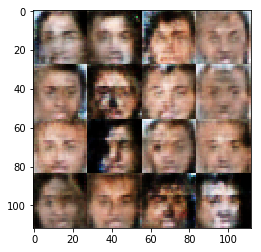

Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 1.0901
Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 1.6323
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 0.9853... Generator Loss: 1.0044
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 0.9794
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 1.1272
Epoch 1/1... Discriminator Loss: 1.2961... Generator Loss: 1.0497
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 1.2061


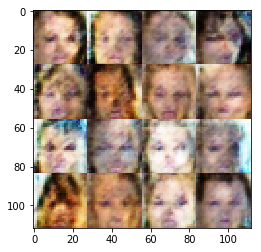

Epoch 1/1... Discriminator Loss: 1.8015... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.5796... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.1888... Generator Loss: 1.1633
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 1.0419
Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 0.9622
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 1.2248


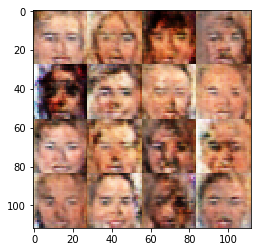

Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 1.3040
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 1.0044
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 1.0555
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 1.1892
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 0.8971
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.9384
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 1.3857
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 1.1577
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 1.5830... Generator Loss: 1.1135


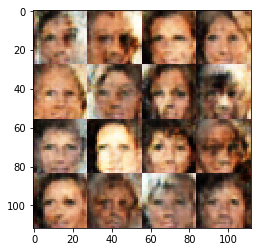

Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.9423
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 1.6168
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 1.0000
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.9394
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 1.1316... Generator Loss: 1.1909
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 1.1636
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 1.0562
Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 1.3192


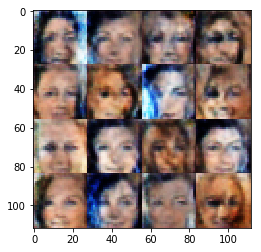

Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.9801
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 1.1841
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.3411
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 1.0902
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 1.1428
Epoch 1/1... Discriminator Loss: 1.0524... Generator Loss: 1.1624
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 1.0394
Epoch 1/1... Discriminator Loss: 1.5971... Generator Loss: 0.8235


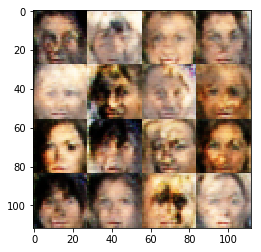

Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 1.1481
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.8769
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 1.3742
Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 1.0062
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 1.0290
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.8723
Epoch 1/1... Discriminator Loss: 1.2199... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 1.3461


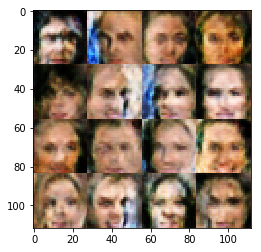

Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.9965
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 1.2011
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 1.0347
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 1.3831
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 1.3270
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.9226
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.8551
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 1.2563


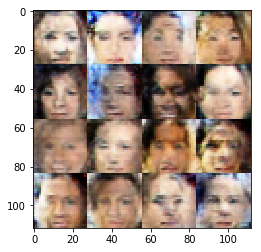

Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.9229
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.9476
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 1.0964
Epoch 1/1... Discriminator Loss: 1.1759... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 1.0048
Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 1.0645
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 1.0443
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 1.2165


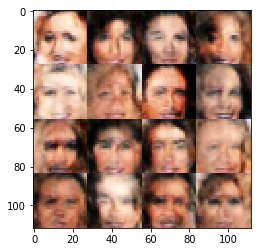

Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.5779... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 1.1015
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.9221
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.8912
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 1.3277
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 1.0602
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.7881


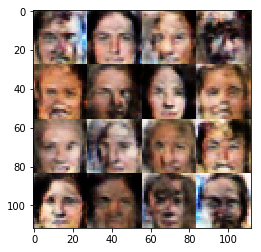

Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.9395
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 1.2213
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 1.0960
Epoch 1/1... Discriminator Loss: 1.5216... Generator Loss: 1.2862
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 1.0120
Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 0.9913... Generator Loss: 0.9843
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.9096
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.8728
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 1.0061


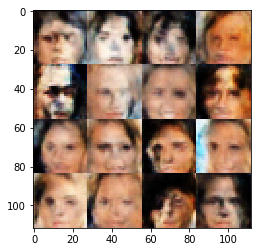

Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 1.0661
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.0369... Generator Loss: 1.0133
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 1.0350
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.9132
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 1.0664
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 1.0178
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.9836
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 1.0330


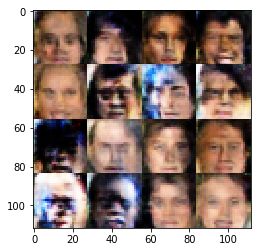

Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 1.0531
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 1.0062
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 0.9964
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 1.0152
Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.6832


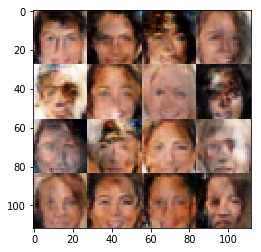

Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 1.2323
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 1.1574
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 1.0089
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.9173
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 1.0728
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 1.0697
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 1.1434
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.9835


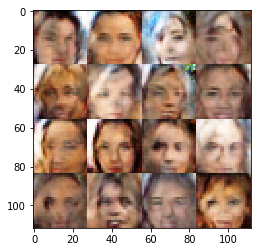

Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 1.1403
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.9642
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 1.0273
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 1.0430
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 1.0554
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.8962


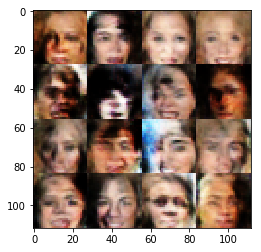

Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.9918
Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.9770
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 0.9789
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.9256
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 1.0673


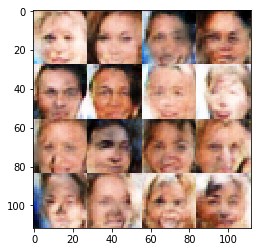

Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 0.9211
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.5352... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 1.0795
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.1441... Generator Loss: 0.9507
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.8757


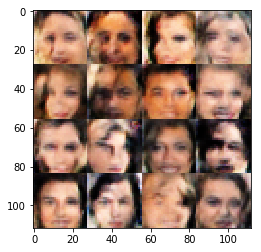

Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.9146
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.9579
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.9631
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 1.1275
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.9188


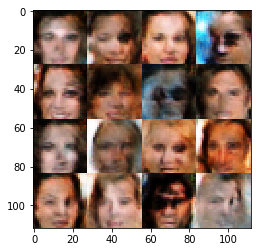

Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 1.0174
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 1.0342
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.8567
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.9714
Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.9863


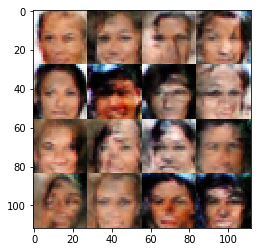

Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 0.9042
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 1.0216
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 1.0434
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 1.0759
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 1.0726
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.9292
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 1.0791
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 1.0040


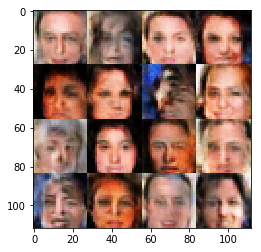

Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 1.1582
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.9135
Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.9186
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 0.9351
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 1.2102
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.9883
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.8748


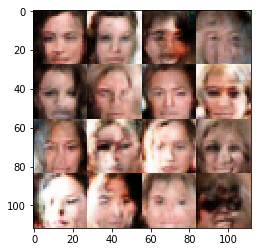

Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 1.0794
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.9541
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 1.1672
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.9874


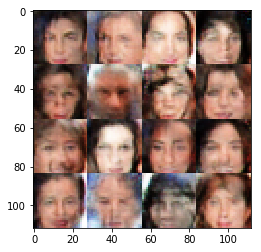

Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.9115
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.9919
Epoch 1/1... Discriminator Loss: 1.5023... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.9991
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.8417


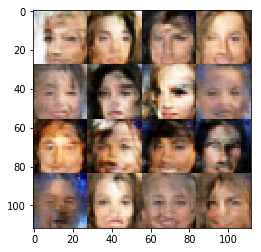

Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.9929
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.9164
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.9922
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.9407
Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.5938


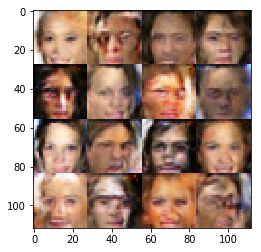

Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.9424
Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 0.8786
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.9062
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 1.1515
Epoch 1/1... Discriminator Loss: 1.4921... Generator Loss: 0.9218
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 1.0409
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.9258
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 1.1032
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.7739


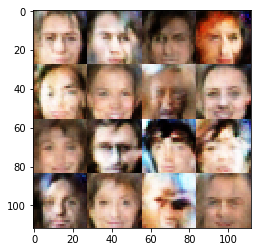

Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 1.0482
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.9870
Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 0.9023
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 1.0295
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 0.9691
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 1.2125
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 1.0481
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 1.0136


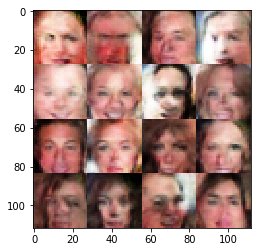

Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.9713
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.9665
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 1.0446
Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 0.9014
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.9920
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.8292


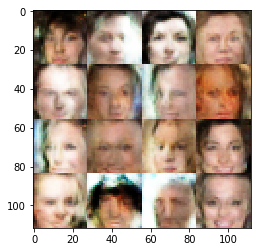

Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 1.0696
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 1.0320
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.9295
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.9137
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.7242


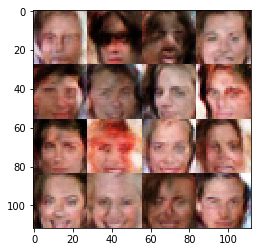

Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.8916
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.9972
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.9752


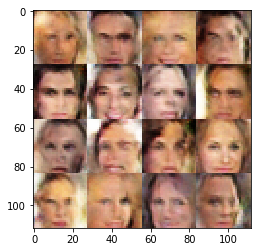

Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 1.0421
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.9366
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.8739
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.9357
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 0.8767
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 1.1423
Epoch 1/1... Discriminator Loss: 1.5449... Generator Loss: 0.8306


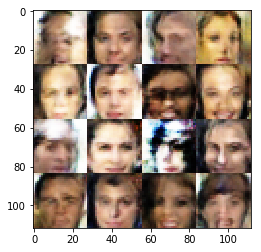

Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.9773
Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 1.5291... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 1.0038
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 1.0257
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.9561
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 0.8477


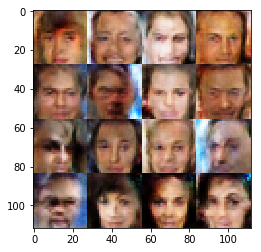

Epoch 1/1... Discriminator Loss: 1.5047... Generator Loss: 0.9171
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.9980
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.9116
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 1.0675
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.8763


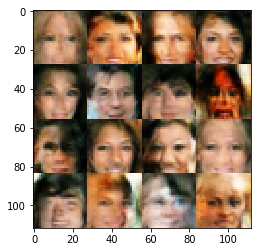

Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.9303
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 1.0244
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.9931
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.8746
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.9204
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 1.0399


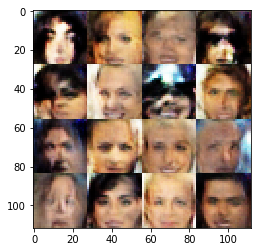

Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.9468
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 1.0315
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.9141
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.9275
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 1.0079


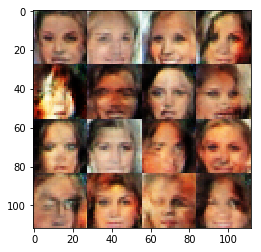

Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 0.9342
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 1.0817
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.8863
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.8540
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.8426


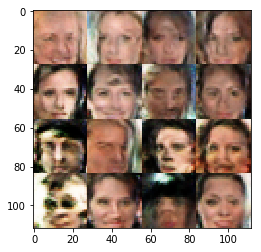

Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.9805
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.9143
Epoch 1/1... Discriminator Loss: 1.5353... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 1.0238
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.9113
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.9631


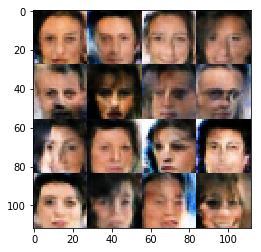

Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.9431
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.8947
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.9475
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.9881
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.9688
Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.8196


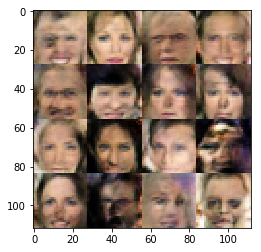

Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.9151
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.9824
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.9314
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.8732
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.9227
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.9167


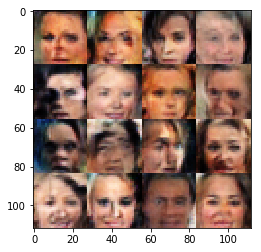

Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.9692
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.9519
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.9747
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.8834


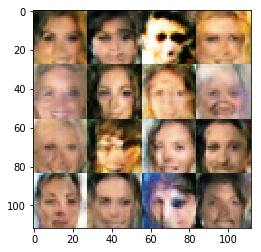

Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.9786
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.9168
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.9617
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.9726
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.9234
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.8392


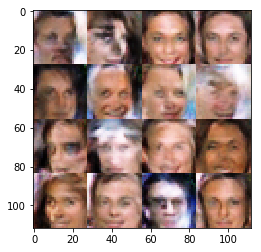

Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 1.0566
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 1.0916
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.8566
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.9463
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.8876


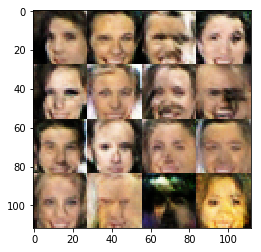

Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.9721
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 1.0101
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.9217
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.5183... Generator Loss: 0.9935
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 1.1083
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.8041


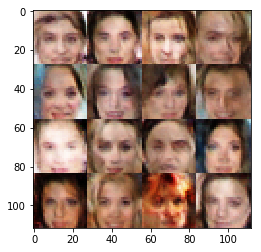

Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.9141
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.9506
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 1.0095
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.8939
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.9216
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 1.0005
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.9481


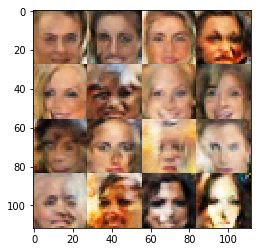

Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.9068
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.8979
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 1.0561
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.8280


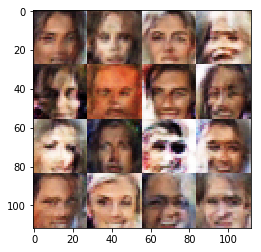

Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.9456
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.9907
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 1.1269
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.8698
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 1.5517... Generator Loss: 0.8686


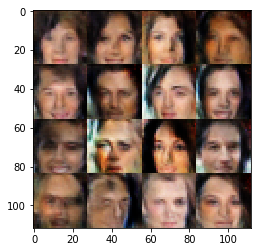

Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 0.8436
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.9640
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.9517
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 1.0332
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.8400


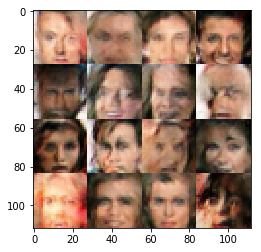

Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 1.0141
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.9526
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.9115
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.8588
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.9870
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 1.0830
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.8483


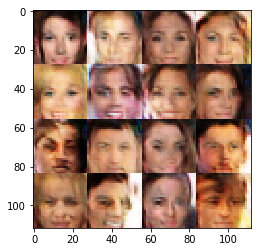

Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.9554
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 0.9496
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.8947
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 1.0317
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7757


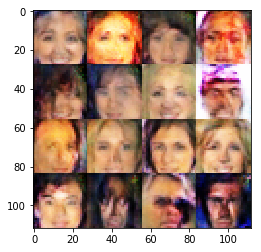

Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.9936
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.9713
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.9722
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.9459
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.8417


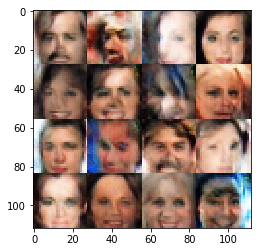

Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 1.0475
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 1.1691
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.9377
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 1.0551
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.8619
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.8309


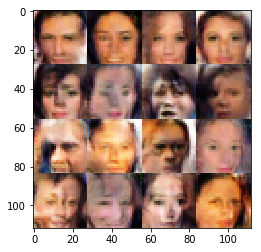

Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.8972
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.9157
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.9858
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.9213
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.8629
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.8539


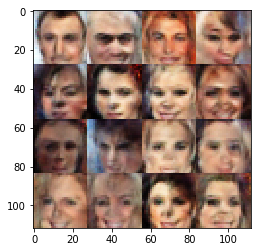

Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.9871
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 1.0152
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.9828
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.8626
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.8890
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.8084


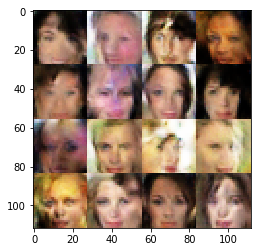

Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.9715
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 1.0628
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.8391


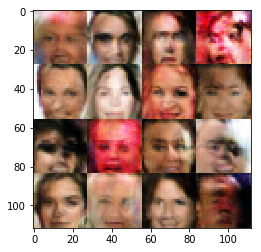

Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 1.0544
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.9436
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.8788
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.9376
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.9282
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.9453


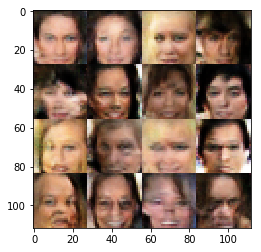

Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.9240
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.9725
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.8596
Final images:


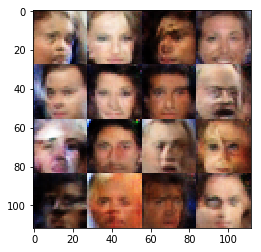

In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.